#  CE-40710: Deep Learning
#  Fall 2023 - Dr. Beigy 

## Homework 5: VAE


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [4]:
CUDA = True
BATCH_SIZE = 128
LEARNING_RATE = 0.01

---

In [5]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [6]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [7]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate=0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.input_dropout = nn.Dropout(p=dropout_rate,inplace=True)
        ######################## END TODO ########################
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions

        encoder_szs = [input_dim] + encoder_dims
        for in_sz,out_sz, in zip(encoder_szs[:-1], encoder_szs[1:]):
            encoder_layers.append(nn.Linear(in_sz, out_sz))
            encoder_layers.append(nn.ReLU())

        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function

        self.mu_layer = nn.Linear(encoder_last_dim, z_dim)
        self.log_var_layer = nn.Linear(encoder_last_dim, z_dim)

        ######################## END TODO ########################
        
        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function

        decoder_szs = [z_dim] + decoder_dims
        for in_sz,out_sz, in zip(decoder_szs[:-1], decoder_szs[1:]):
            decoder_layers.append(nn.Linear(in_sz, out_sz))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_szs[-1], input_dim))

        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)

    @staticmethod
    def _sampling(mu, log_var):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps*std
        ######################## END TODO ########################
        return z

    def forward(self, data):
        x = data.get("X")
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output

        x = self.input_dropout(x)
        x = self.encoder(x)
        mu = self.mu_layer(x)
        log_var = self.log_var_layer(x)
        z = self._sampling(mu,log_var)
        output = self.decoder(z)
        ######################## END TODO ########################
        return {"X": output, "mu": mu, "log_var": log_var, "z": z}
    
    def loss(self, data, output):
      x = data.get("X")
      recon_x = output.get("X")
      mu = output.get("mu")
      log_var = output.get("log_var")
      ########################## TODO ##########################
      # Calculate MSE and KLD
      MSE = ((x - recon_x)**2).sum()
      KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
      ######################## END TODO ########################
      return {"final": MSE + KLD, "KLD": KLD, "MSE": MSE}

---

In [9]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        # Use `flatten` function from pytorch
        data['X'] = torch.flatten(data['X'],start_dim = 1)
        ######################## END TODO ########################

        if CUDA:
            ########################## TODO ##########################
            # Send tensors in data to GPU
            data['X'] , data['Y'] = data['X'].cuda(), data['Y'].cuda()
            ######################## END TODO ########################


        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()
        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data["X"]), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data["X"])))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [10]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            data['X'] = torch.flatten(data['X'],start_dim = 1)
            ######################## END TODO ########################

            if CUDA:
                ########################## TODO ##########################
                # Send tensors in data to GPU
                data['X'] , data['Y'] = data['X'].cuda(), data['Y'].cuda()
                ######################## END TODO ########################

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()

            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)

    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [11]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if CUDA:
        model.cuda()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    optimizer = optim.Adam(model.parameters(), lr= LEARNING_RATE / BATCH_SIZE)
    ######################## END TODO ########################

    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [12]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [13]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512])
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (input_dropout): Dropout(p=0.2, inplace=True)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [14]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if CUDA:
        input_img = input_img.cuda()
    recons_img = vae({"X": input_img})["X"]
    recons_img = recons_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if CUDA:
        z = z.cuda()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 120.780060
Train | Epoch: 1 [12800/60000 (21%)]	Loss: 77.481003
Train | Epoch: 1 [25600/60000 (43%)]	Loss: 79.558182
Train | Epoch: 1 [38400/60000 (64%)]	Loss: 76.181465
Train | Epoch: 1 [51200/60000 (85%)]	Loss: 71.165764
====> Train | Epoch: 1 	 | 	 Average loss: 78.1943
====> Test  | model loss: 50.2754
Inputs:


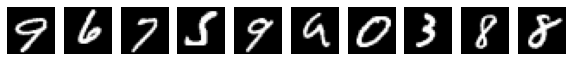

Reconstructions:


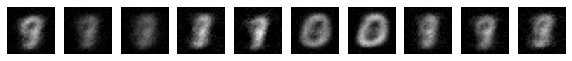

Generated Images:


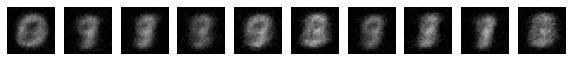

Train | Epoch: 2 [0/60000 (0%)]	Loss: 71.796364
Train | Epoch: 2 [12800/60000 (21%)]	Loss: 66.442848
Train | Epoch: 2 [25600/60000 (43%)]	Loss: 66.627899
Train | Epoch: 2 [38400/60000 (64%)]	Loss: 68.791817
Train | Epoch: 2 [51200/60000 (85%)]	Loss: 66.461685
====> Train | Epoch: 2 	 | 	 Average loss: 68.2877
====> Test  | model loss: 44.0465
Inputs:


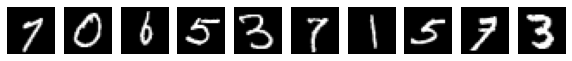

Reconstructions:


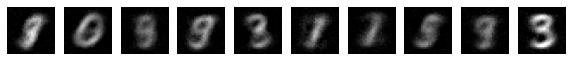

Generated Images:


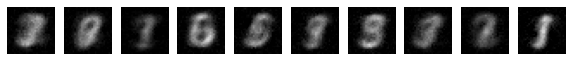

Train | Epoch: 3 [0/60000 (0%)]	Loss: 63.762520
Train | Epoch: 3 [12800/60000 (21%)]	Loss: 63.876213
Train | Epoch: 3 [25600/60000 (43%)]	Loss: 63.606342
Train | Epoch: 3 [38400/60000 (64%)]	Loss: 64.363647
Train | Epoch: 3 [51200/60000 (85%)]	Loss: 65.289940
====> Train | Epoch: 3 	 | 	 Average loss: 64.6417
====> Test  | model loss: 41.8888
Inputs:


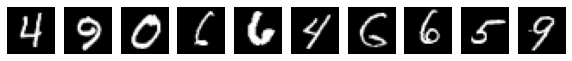

Reconstructions:


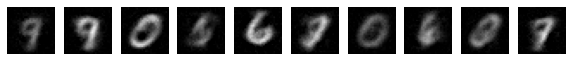

Generated Images:


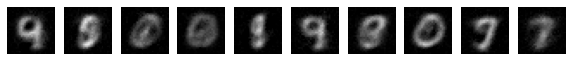

Train | Epoch: 4 [0/60000 (0%)]	Loss: 61.633663
Train | Epoch: 4 [12800/60000 (21%)]	Loss: 64.322914
Train | Epoch: 4 [25600/60000 (43%)]	Loss: 60.101719
Train | Epoch: 4 [38400/60000 (64%)]	Loss: 59.105934
Train | Epoch: 4 [51200/60000 (85%)]	Loss: 64.533424
====> Train | Epoch: 4 	 | 	 Average loss: 62.8389
====> Test  | model loss: 40.3647
Inputs:


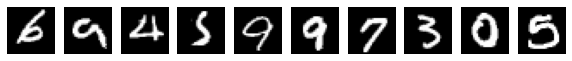

Reconstructions:


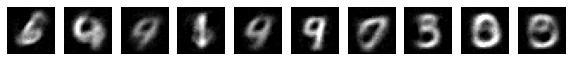

Generated Images:


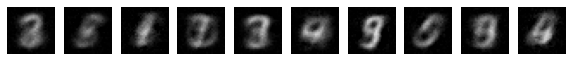

Train | Epoch: 5 [0/60000 (0%)]	Loss: 63.616478
Train | Epoch: 5 [12800/60000 (21%)]	Loss: 61.914074
Train | Epoch: 5 [25600/60000 (43%)]	Loss: 60.477261
Train | Epoch: 5 [38400/60000 (64%)]	Loss: 60.973991
Train | Epoch: 5 [51200/60000 (85%)]	Loss: 60.747917
====> Train | Epoch: 5 	 | 	 Average loss: 61.4318
====> Test  | model loss: 39.2284
Inputs:


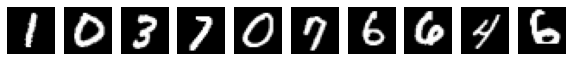

Reconstructions:


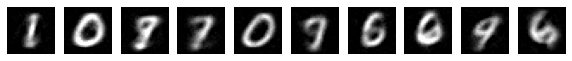

Generated Images:


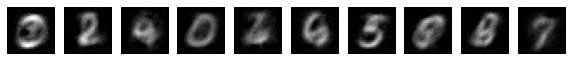

Train | Epoch: 6 [0/60000 (0%)]	Loss: 61.327343
Train | Epoch: 6 [12800/60000 (21%)]	Loss: 61.537018
Train | Epoch: 6 [25600/60000 (43%)]	Loss: 61.639381
Train | Epoch: 6 [38400/60000 (64%)]	Loss: 60.897110
Train | Epoch: 6 [51200/60000 (85%)]	Loss: 58.729103
====> Train | Epoch: 6 	 | 	 Average loss: 60.3318
====> Test  | model loss: 38.1501
Inputs:


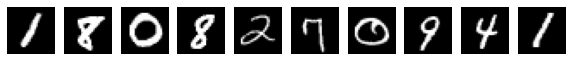

Reconstructions:


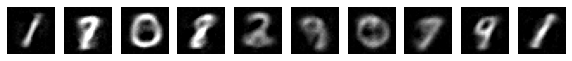

Generated Images:


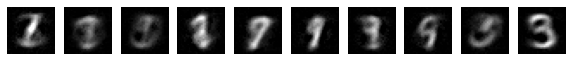

Train | Epoch: 7 [0/60000 (0%)]	Loss: 58.686176
Train | Epoch: 7 [12800/60000 (21%)]	Loss: 60.329685
Train | Epoch: 7 [25600/60000 (43%)]	Loss: 59.729595
Train | Epoch: 7 [38400/60000 (64%)]	Loss: 62.139893
Train | Epoch: 7 [51200/60000 (85%)]	Loss: 57.395096
====> Train | Epoch: 7 	 | 	 Average loss: 59.3613
====> Test  | model loss: 37.3363
Inputs:


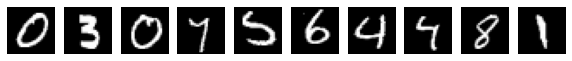

Reconstructions:


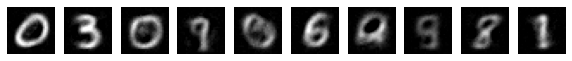

Generated Images:


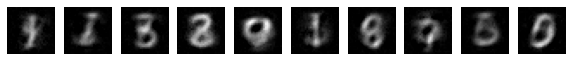

Train | Epoch: 8 [0/60000 (0%)]	Loss: 58.880989
Train | Epoch: 8 [12800/60000 (21%)]	Loss: 58.370445
Train | Epoch: 8 [25600/60000 (43%)]	Loss: 58.454147
Train | Epoch: 8 [38400/60000 (64%)]	Loss: 56.453003
Train | Epoch: 8 [51200/60000 (85%)]	Loss: 59.313194
====> Train | Epoch: 8 	 | 	 Average loss: 58.5419
====> Test  | model loss: 36.6023
Inputs:


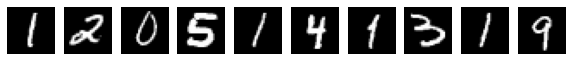

Reconstructions:


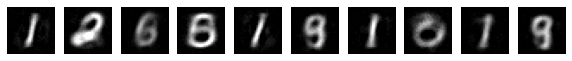

Generated Images:


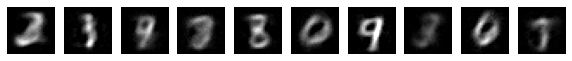

Train | Epoch: 9 [0/60000 (0%)]	Loss: 56.580956
Train | Epoch: 9 [12800/60000 (21%)]	Loss: 58.159775
Train | Epoch: 9 [25600/60000 (43%)]	Loss: 57.490459
Train | Epoch: 9 [38400/60000 (64%)]	Loss: 56.242805
Train | Epoch: 9 [51200/60000 (85%)]	Loss: 57.151096
====> Train | Epoch: 9 	 | 	 Average loss: 57.8516
====> Test  | model loss: 35.9633
Inputs:


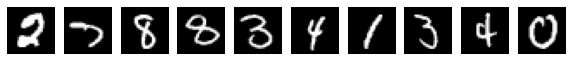

Reconstructions:


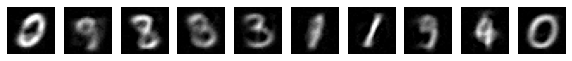

Generated Images:


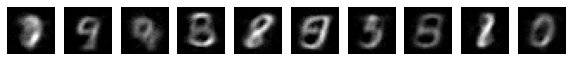

Train | Epoch: 10 [0/60000 (0%)]	Loss: 57.876671
Train | Epoch: 10 [12800/60000 (21%)]	Loss: 61.548740
Train | Epoch: 10 [25600/60000 (43%)]	Loss: 58.668678
Train | Epoch: 10 [38400/60000 (64%)]	Loss: 58.122692
Train | Epoch: 10 [51200/60000 (85%)]	Loss: 55.988998
====> Train | Epoch: 10 	 | 	 Average loss: 57.2740
====> Test  | model loss: 35.7101
Inputs:


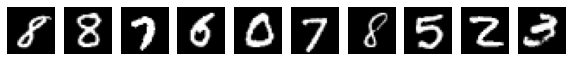

Reconstructions:


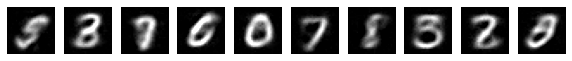

Generated Images:


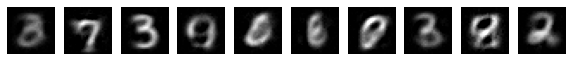

Train | Epoch: 11 [0/60000 (0%)]	Loss: 57.267181
Train | Epoch: 11 [12800/60000 (21%)]	Loss: 56.465729
Train | Epoch: 11 [25600/60000 (43%)]	Loss: 54.660084
Train | Epoch: 11 [38400/60000 (64%)]	Loss: 57.106941
Train | Epoch: 11 [51200/60000 (85%)]	Loss: 56.863220
====> Train | Epoch: 11 	 | 	 Average loss: 56.7672
====> Test  | model loss: 34.9199
Inputs:


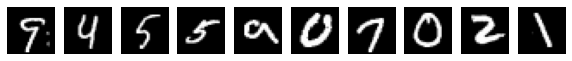

Reconstructions:


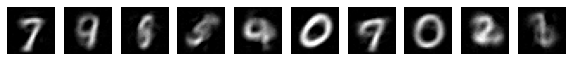

Generated Images:


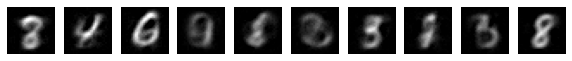

Train | Epoch: 12 [0/60000 (0%)]	Loss: 56.178703
Train | Epoch: 12 [12800/60000 (21%)]	Loss: 55.675106
Train | Epoch: 12 [25600/60000 (43%)]	Loss: 54.560310
Train | Epoch: 12 [38400/60000 (64%)]	Loss: 54.849953
Train | Epoch: 12 [51200/60000 (85%)]	Loss: 55.410599
====> Train | Epoch: 12 	 | 	 Average loss: 56.3182
====> Test  | model loss: 34.5465
Inputs:


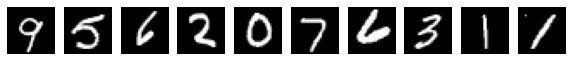

Reconstructions:


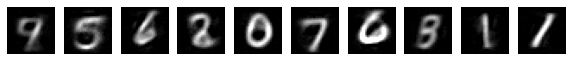

Generated Images:


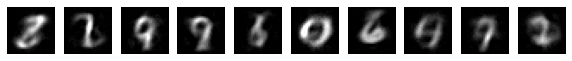

Train | Epoch: 13 [0/60000 (0%)]	Loss: 55.866653
Train | Epoch: 13 [12800/60000 (21%)]	Loss: 56.031818
Train | Epoch: 13 [25600/60000 (43%)]	Loss: 56.093086
Train | Epoch: 13 [38400/60000 (64%)]	Loss: 56.522682
Train | Epoch: 13 [51200/60000 (85%)]	Loss: 56.756275
====> Train | Epoch: 13 	 | 	 Average loss: 55.9613
====> Test  | model loss: 34.1686
Inputs:


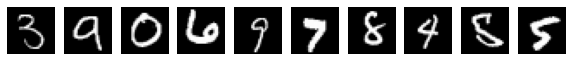

Reconstructions:


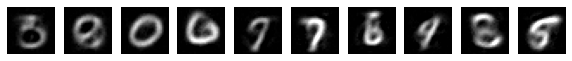

Generated Images:


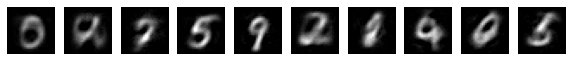

Train | Epoch: 14 [0/60000 (0%)]	Loss: 54.955227
Train | Epoch: 14 [12800/60000 (21%)]	Loss: 55.916794
Train | Epoch: 14 [25600/60000 (43%)]	Loss: 54.231571
Train | Epoch: 14 [38400/60000 (64%)]	Loss: 56.063980
Train | Epoch: 14 [51200/60000 (85%)]	Loss: 56.659706
====> Train | Epoch: 14 	 | 	 Average loss: 55.6194
====> Test  | model loss: 33.8868
Inputs:


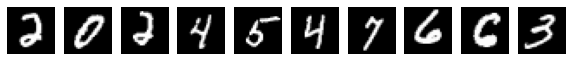

Reconstructions:


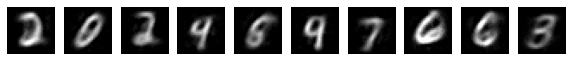

Generated Images:


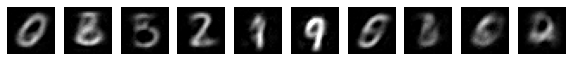

Train | Epoch: 15 [0/60000 (0%)]	Loss: 56.107338
Train | Epoch: 15 [12800/60000 (21%)]	Loss: 53.555977
Train | Epoch: 15 [25600/60000 (43%)]	Loss: 53.859936
Train | Epoch: 15 [38400/60000 (64%)]	Loss: 56.941048
Train | Epoch: 15 [51200/60000 (85%)]	Loss: 54.062901
====> Train | Epoch: 15 	 | 	 Average loss: 55.3265
====> Test  | model loss: 33.6602
Inputs:


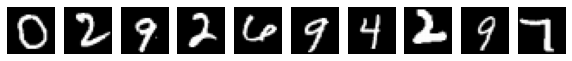

Reconstructions:


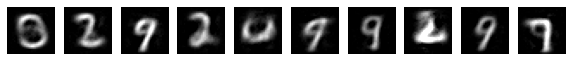

Generated Images:


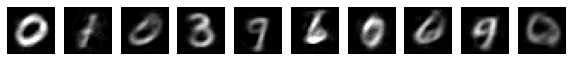

Train | Epoch: 16 [0/60000 (0%)]	Loss: 57.075958
Train | Epoch: 16 [12800/60000 (21%)]	Loss: 56.124485
Train | Epoch: 16 [25600/60000 (43%)]	Loss: 54.495068
Train | Epoch: 16 [38400/60000 (64%)]	Loss: 55.570477
Train | Epoch: 16 [51200/60000 (85%)]	Loss: 54.117977
====> Train | Epoch: 16 	 | 	 Average loss: 55.0989
====> Test  | model loss: 33.4747
Inputs:


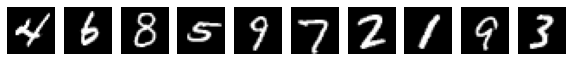

Reconstructions:


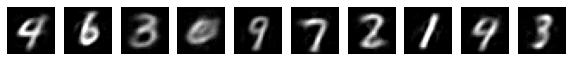

Generated Images:


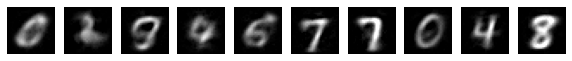

Train | Epoch: 17 [0/60000 (0%)]	Loss: 55.164406
Train | Epoch: 17 [12800/60000 (21%)]	Loss: 56.781193
Train | Epoch: 17 [25600/60000 (43%)]	Loss: 55.980637
Train | Epoch: 17 [38400/60000 (64%)]	Loss: 54.574081
Train | Epoch: 17 [51200/60000 (85%)]	Loss: 53.131275
====> Train | Epoch: 17 	 | 	 Average loss: 54.8506
====> Test  | model loss: 33.2041
Inputs:


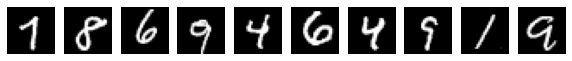

Reconstructions:


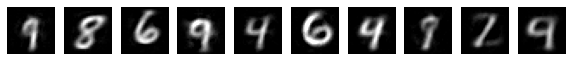

Generated Images:


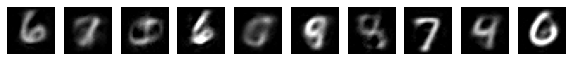

Train | Epoch: 18 [0/60000 (0%)]	Loss: 53.886391
Train | Epoch: 18 [12800/60000 (21%)]	Loss: 54.013199
Train | Epoch: 18 [25600/60000 (43%)]	Loss: 57.736328
Train | Epoch: 18 [38400/60000 (64%)]	Loss: 54.590042
Train | Epoch: 18 [51200/60000 (85%)]	Loss: 54.581348
====> Train | Epoch: 18 	 | 	 Average loss: 54.6396
====> Test  | model loss: 33.0249
Inputs:


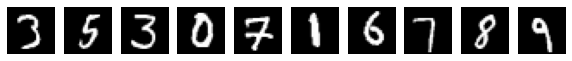

Reconstructions:


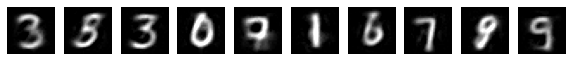

Generated Images:


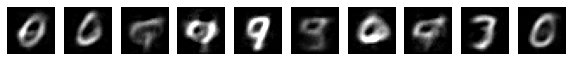

Train | Epoch: 19 [0/60000 (0%)]	Loss: 55.202900
Train | Epoch: 19 [12800/60000 (21%)]	Loss: 52.961456
Train | Epoch: 19 [25600/60000 (43%)]	Loss: 53.063736
Train | Epoch: 19 [38400/60000 (64%)]	Loss: 53.738094
Train | Epoch: 19 [51200/60000 (85%)]	Loss: 54.297813
====> Train | Epoch: 19 	 | 	 Average loss: 54.4385
====> Test  | model loss: 32.7997
Inputs:


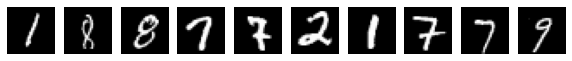

Reconstructions:


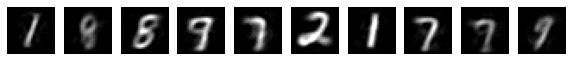

Generated Images:


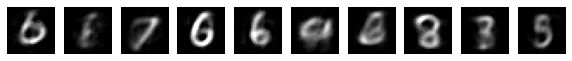

Train | Epoch: 20 [0/60000 (0%)]	Loss: 55.325260
Train | Epoch: 20 [12800/60000 (21%)]	Loss: 51.879742
Train | Epoch: 20 [25600/60000 (43%)]	Loss: 52.894424
Train | Epoch: 20 [38400/60000 (64%)]	Loss: 53.519051
Train | Epoch: 20 [51200/60000 (85%)]	Loss: 57.008762
====> Train | Epoch: 20 	 | 	 Average loss: 54.2620
====> Test  | model loss: 32.6082
Inputs:


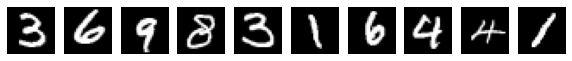

Reconstructions:


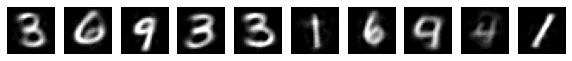

Generated Images:


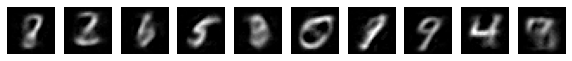

Train | Epoch: 21 [0/60000 (0%)]	Loss: 52.874649
Train | Epoch: 21 [12800/60000 (21%)]	Loss: 54.391308
Train | Epoch: 21 [25600/60000 (43%)]	Loss: 55.138241
Train | Epoch: 21 [38400/60000 (64%)]	Loss: 53.264900
Train | Epoch: 21 [51200/60000 (85%)]	Loss: 53.570129
====> Train | Epoch: 21 	 | 	 Average loss: 54.0842
====> Test  | model loss: 32.4882
Inputs:


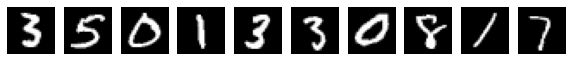

Reconstructions:


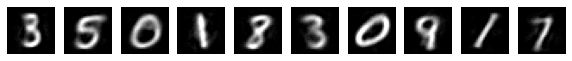

Generated Images:


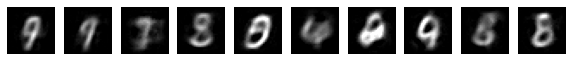

Train | Epoch: 22 [0/60000 (0%)]	Loss: 52.966236
Train | Epoch: 22 [12800/60000 (21%)]	Loss: 53.919823
Train | Epoch: 22 [25600/60000 (43%)]	Loss: 54.151947
Train | Epoch: 22 [38400/60000 (64%)]	Loss: 57.625488
Train | Epoch: 22 [51200/60000 (85%)]	Loss: 55.821362
====> Train | Epoch: 22 	 | 	 Average loss: 53.9290
====> Test  | model loss: 32.4007
Inputs:


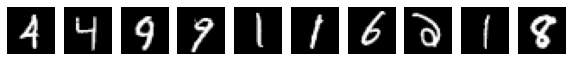

Reconstructions:


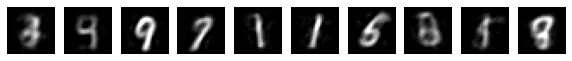

Generated Images:


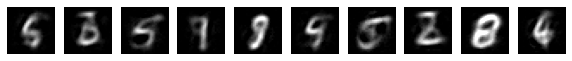

Train | Epoch: 23 [0/60000 (0%)]	Loss: 53.976063
Train | Epoch: 23 [12800/60000 (21%)]	Loss: 53.847057
Train | Epoch: 23 [25600/60000 (43%)]	Loss: 55.518059
Train | Epoch: 23 [38400/60000 (64%)]	Loss: 52.686913
Train | Epoch: 23 [51200/60000 (85%)]	Loss: 52.981831
====> Train | Epoch: 23 	 | 	 Average loss: 53.7978
====> Test  | model loss: 32.2004
Inputs:


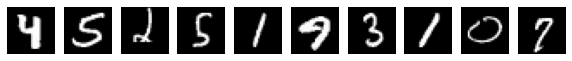

Reconstructions:


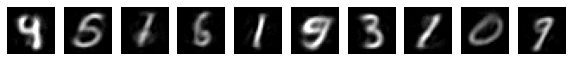

Generated Images:


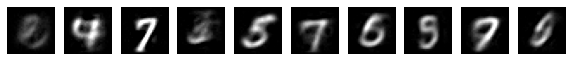

Train | Epoch: 24 [0/60000 (0%)]	Loss: 53.072006
Train | Epoch: 24 [12800/60000 (21%)]	Loss: 54.175316
Train | Epoch: 24 [25600/60000 (43%)]	Loss: 53.081299
Train | Epoch: 24 [38400/60000 (64%)]	Loss: 57.085159
Train | Epoch: 24 [51200/60000 (85%)]	Loss: 53.197998
====> Train | Epoch: 24 	 | 	 Average loss: 53.6553
====> Test  | model loss: 32.1433
Inputs:


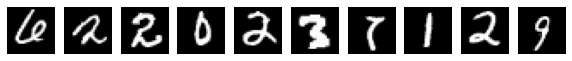

Reconstructions:


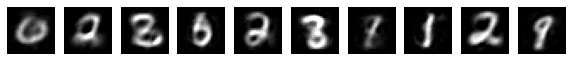

Generated Images:


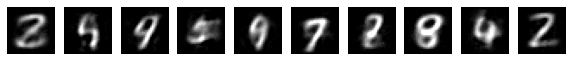

Train | Epoch: 25 [0/60000 (0%)]	Loss: 52.980034
Train | Epoch: 25 [12800/60000 (21%)]	Loss: 53.547871
Train | Epoch: 25 [25600/60000 (43%)]	Loss: 53.075935
Train | Epoch: 25 [38400/60000 (64%)]	Loss: 51.623123
Train | Epoch: 25 [51200/60000 (85%)]	Loss: 53.395500
====> Train | Epoch: 25 	 | 	 Average loss: 53.5298
====> Test  | model loss: 32.0057
Inputs:


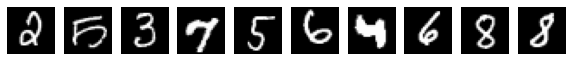

Reconstructions:


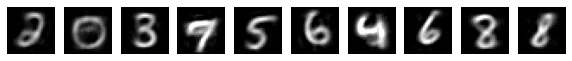

Generated Images:


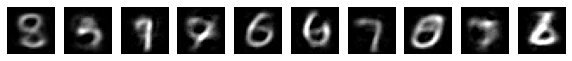

Train | Epoch: 26 [0/60000 (0%)]	Loss: 52.404770
Train | Epoch: 26 [12800/60000 (21%)]	Loss: 55.737698
Train | Epoch: 26 [25600/60000 (43%)]	Loss: 54.283932
Train | Epoch: 26 [38400/60000 (64%)]	Loss: 52.283974
Train | Epoch: 26 [51200/60000 (85%)]	Loss: 54.378120
====> Train | Epoch: 26 	 | 	 Average loss: 53.3913
====> Test  | model loss: 31.9377
Inputs:


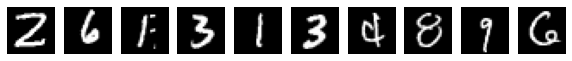

Reconstructions:


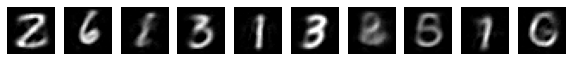

Generated Images:


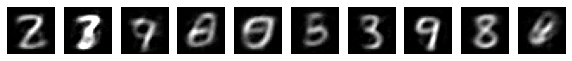

Train | Epoch: 27 [0/60000 (0%)]	Loss: 53.244553
Train | Epoch: 27 [12800/60000 (21%)]	Loss: 55.240978
Train | Epoch: 27 [25600/60000 (43%)]	Loss: 52.145454
Train | Epoch: 27 [38400/60000 (64%)]	Loss: 54.118038
Train | Epoch: 27 [51200/60000 (85%)]	Loss: 52.880249
====> Train | Epoch: 27 	 | 	 Average loss: 53.2974
====> Test  | model loss: 31.7223
Inputs:


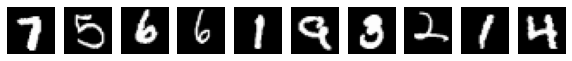

Reconstructions:


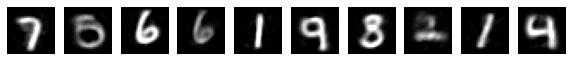

Generated Images:


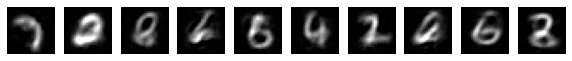

Train | Epoch: 28 [0/60000 (0%)]	Loss: 52.801582
Train | Epoch: 28 [12800/60000 (21%)]	Loss: 53.056458
Train | Epoch: 28 [25600/60000 (43%)]	Loss: 51.853630
Train | Epoch: 28 [38400/60000 (64%)]	Loss: 52.913540
Train | Epoch: 28 [51200/60000 (85%)]	Loss: 53.659718
====> Train | Epoch: 28 	 | 	 Average loss: 53.2325
====> Test  | model loss: 31.5375
Inputs:


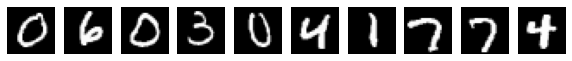

Reconstructions:


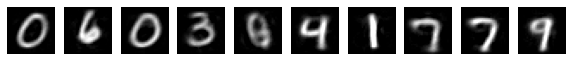

Generated Images:


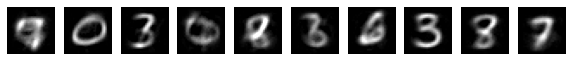

Train | Epoch: 29 [0/60000 (0%)]	Loss: 53.583382
Train | Epoch: 29 [12800/60000 (21%)]	Loss: 50.897392
Train | Epoch: 29 [25600/60000 (43%)]	Loss: 52.734798
Train | Epoch: 29 [38400/60000 (64%)]	Loss: 55.603523
Train | Epoch: 29 [51200/60000 (85%)]	Loss: 54.592918
====> Train | Epoch: 29 	 | 	 Average loss: 53.1034
====> Test  | model loss: 31.6371
Inputs:


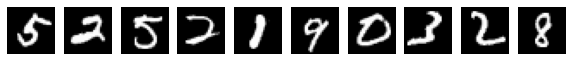

Reconstructions:


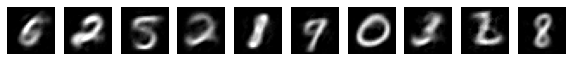

Generated Images:


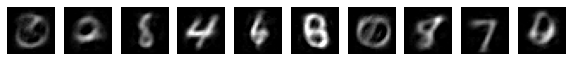

Train | Epoch: 30 [0/60000 (0%)]	Loss: 53.888737
Train | Epoch: 30 [12800/60000 (21%)]	Loss: 51.476135
Train | Epoch: 30 [25600/60000 (43%)]	Loss: 52.095776
Train | Epoch: 30 [38400/60000 (64%)]	Loss: 53.307636
Train | Epoch: 30 [51200/60000 (85%)]	Loss: 54.682549
====> Train | Epoch: 30 	 | 	 Average loss: 53.0185
====> Test  | model loss: 31.5001
Inputs:


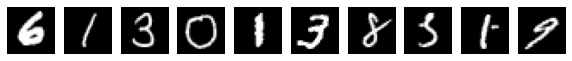

Reconstructions:


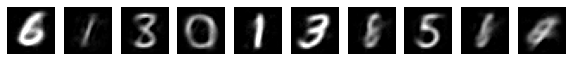

Generated Images:


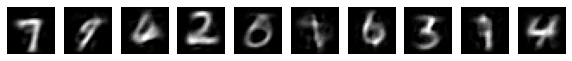

In [15]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [62]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1).cuda()
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1).cuda()
        
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        z_1 = model({"X":img_1})['z']
        z_2 = model({"X": img_2})['z']
        z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n_cols - 2)])
        output = model.decoder(z).reshape(-1, 28, 28).to('cpu').detach().numpy()
        output = np.concatenate((img_1.reshape(1, 28, 28).to('cpu').numpy(), output, img_2.reshape(1, 28 , 28).to('cpu').numpy()), axis=0)
        ######################## END TODO ########################
        
        show(output)

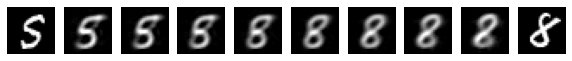

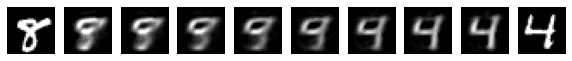

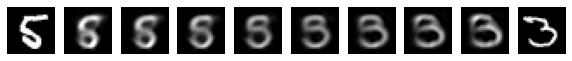

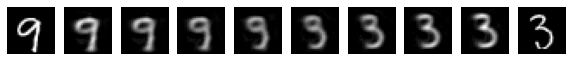

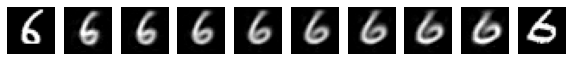

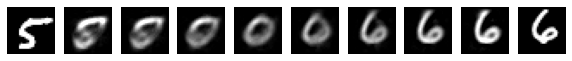

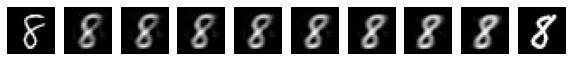

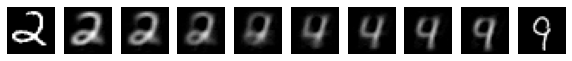

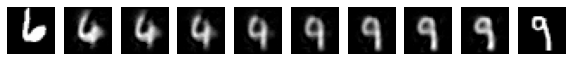

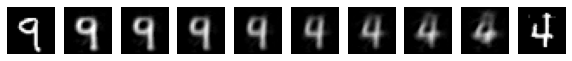

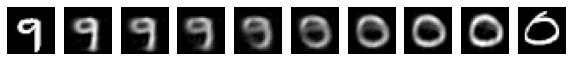

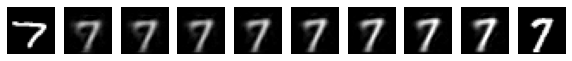

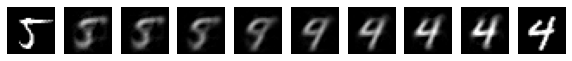

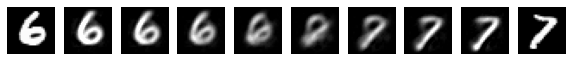

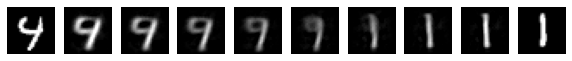

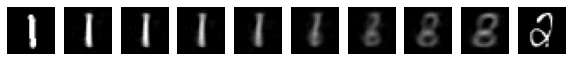

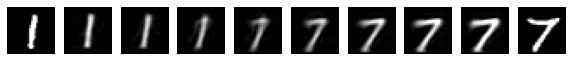

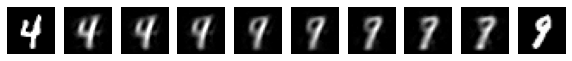

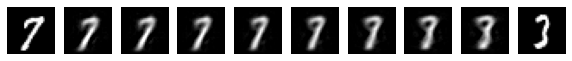

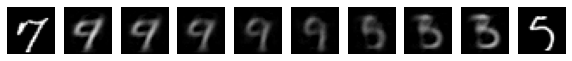

In [63]:
check_interpolations(vae, 20, 10)